In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from data import setup_noise_schedule, cosine_beta_schedule, create_batch
from model import NoisePredictionMLP, sample_ddim

In [2]:
# generate distribution
from distribution import smiley_distr, square_distr
x_points, y_points = smiley_distr(n_mouth=20)
# x_points, y_points = square_distr() 

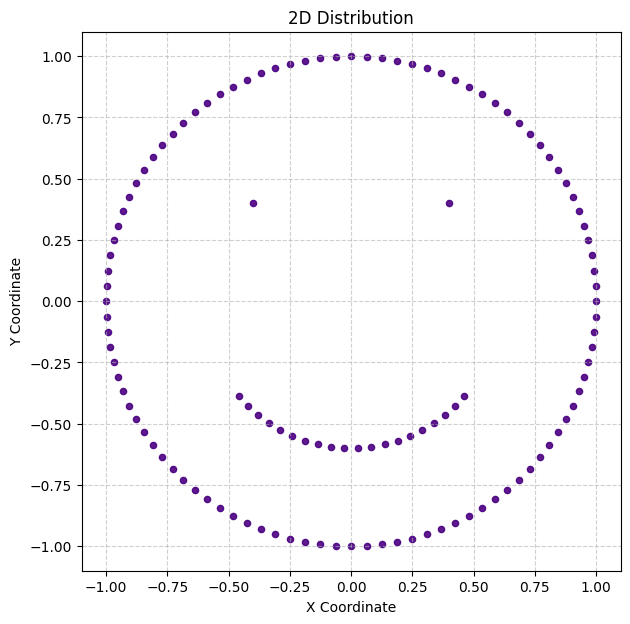

In [3]:
#visualize distribution
def plot_points(x, y):
    """
    Plots the generated 2D points.
    """
    # Increased point size for clearer visibility of the sharp points
    plt.figure(figsize=(7, 7))
    plt.scatter(x, y, s=20, alpha=0.9, color='indigo') 
    plt.title('2D Distribution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().set_aspect('equal', adjustable='box') # Ensure circle looks like a circle
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


plot_points(x_points, y_points)

In [4]:
#eval metric
def chamfer_distance(set_a, set_b):
    """
    Computes the bidirectional Chamfer distance between two point clouds.
    set_a: (N, 2) numpy array (Generated Data)
    set_b: (M, 2) numpy array (Ground Truth Smiley)
    """
    # Convert to tensors if needed
    if isinstance(set_a, np.ndarray): set_a = torch.from_numpy(set_a).float()
    if isinstance(set_b, np.ndarray): set_b = torch.from_numpy(set_b).float()
    
    # Calculate pairwise distances
    # x shape: (N, 1, 2), y shape: (1, M, 2)
    dist = torch.cdist(set_a.unsqueeze(0), set_b.unsqueeze(0)).squeeze(0) # (N, M)
    
    # 1. For each point in A, find closest point in B
    min_dist_a_to_b, _ = torch.min(dist, dim=1)
    
    # 2. For each point in B, find closest point in A
    min_dist_b_to_a, _ = torch.min(dist, dim=0)
    
    # Average distance
    return torch.mean(min_dist_a_to_b) + torch.mean(min_dist_b_to_a)

# --- USAGE in Training Loop ---
# Every 2000 steps:
# 1. Generate 500 points using sample_ddim(model, ...)
# 2. Generate 500 points using smiley_distr(...)
# 3. dist = chamfer_distance(generated, ground_truth)
# 4. print(f"Chamfer Distance: {dist:.4f}")

In [5]:
T_STEPS = 1000           # Total diffusion time steps
BATCH_SIZE = 512
ACCUMULATION_STEPS = 2
LEARNING_RATE = 1e-3
NUM_ITERATIONS = 50000   # Total training steps (since the dataset is small)
LOG_INTERVAL = 500

In [7]:
#train model
alpha_bars, betas = setup_noise_schedule(T_STEPS)
# alpha_bars, betas = cosine_beta_schedule(T_STEPS)

model = NoisePredictionMLP()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss() # The standard loss for noise prediction

# --- TRAINING LOOP ---
print("\nStarting DDIM Training...")
losses = []
chamfer = []

optimizer.zero_grad()
for i in range(1, NUM_ITERATIONS + 1):
    # 1. Generate a batch of data
    
    x_t, t_raw, output = create_batch(alpha_bars, x_points, y_points, BATCH_SIZE)

    # t_normalized = t_raw/T_STEPS
    processed_input = torch.cat([x_t, t_raw], dim=1)
    
    # 3. Zero the gradients
    
    # 4. Forward pass
    predicted_noise = model(processed_input)
    
    # 5. Calculate loss
    # The loss is the difference between the true noise and the predicted noise
    loss = criterion(predicted_noise, output)
    
    # 6. Backward pass and optimization step
    loss.backward()

    #don't reset grad every epoch
    if i % ACCUMULATION_STEPS == 0:
        optimizer.step()
        optimizer.zero_grad()
    
    # 7. Logging
    losses.append(loss.item())
    if i % LOG_INTERVAL == 0:
        print(f"Iteration: {i}/{NUM_ITERATIONS} | Loss: {loss.item():.6f}")

        #test chamfer metric too
        test_x = [np.random.normal(0,2) for i in range(len(x_points))]
        test_y = [np.random.normal(0,2) for i in range(len(x_points))]

        ddim_data, _ = sample_ddim(model, 1000, alpha_bars, inference_steps=20, eta=0.0)
        ground_truth = np.stack([x_points, y_points], axis=1)
        dist = chamfer_distance(ddim_data, ground_truth)
        print(f"Chamfer Distance: {dist:.4f}")
        chamfer.append(dist)

print("\nTraining complete.")
# You would typically save the model weights here: 
# torch.save(model.state_dict(), 'smiley_ddpm_model.pth')



Starting DDIM Training...
Iteration: 500/50000 | Loss: 0.212611
DDIM Sampling with 20 steps...
Chamfer Distance: 0.2616
Iteration: 1000/50000 | Loss: 0.218236
DDIM Sampling with 20 steps...
Chamfer Distance: 0.2090
Iteration: 1500/50000 | Loss: 0.209364
DDIM Sampling with 20 steps...
Chamfer Distance: 0.1136
Iteration: 2000/50000 | Loss: 0.188338
DDIM Sampling with 20 steps...
Chamfer Distance: 0.1456
Iteration: 2500/50000 | Loss: 0.180935
DDIM Sampling with 20 steps...
Chamfer Distance: 0.1796
Iteration: 3000/50000 | Loss: 0.187001
DDIM Sampling with 20 steps...
Chamfer Distance: 0.1338
Iteration: 3500/50000 | Loss: 0.188719
DDIM Sampling with 20 steps...
Chamfer Distance: 0.1205
Iteration: 4000/50000 | Loss: 0.146121
DDIM Sampling with 20 steps...
Chamfer Distance: 0.0940
Iteration: 4500/50000 | Loss: 0.168316
DDIM Sampling with 20 steps...
Chamfer Distance: 0.0847
Iteration: 5000/50000 | Loss: 0.196580
DDIM Sampling with 20 steps...
Chamfer Distance: 0.1056
Iteration: 5500/50000 | 

In [8]:
#quick test to see if model learns timesteps (larger is better)
# Take ONE point
test_x = torch.tensor([[0.5, 0.5]]) 
 
# Ask model: "What is the noise at t=1?" (Should be small/specific)
t1 = torch.tensor([[1.0]])
out1 = model(torch.cat([test_x, t1], dim=1))

# Ask model: "What is the noise at t=99?" (Should be large/different)
t99 = torch.tensor([[999.0]])
out99 = model(torch.cat([test_x, t99], dim=1))

print(f"Diff between t=1 and t=999 predictions: {(out1 - out99).abs().mean().item()}")

Diff between t=1 and t=999 predictions: 1.7092036008834839


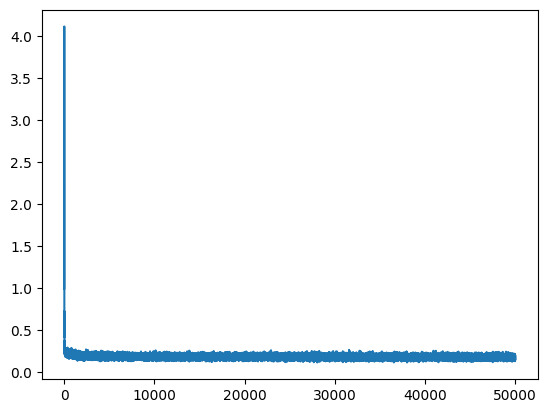

In [9]:
plt.plot(losses)

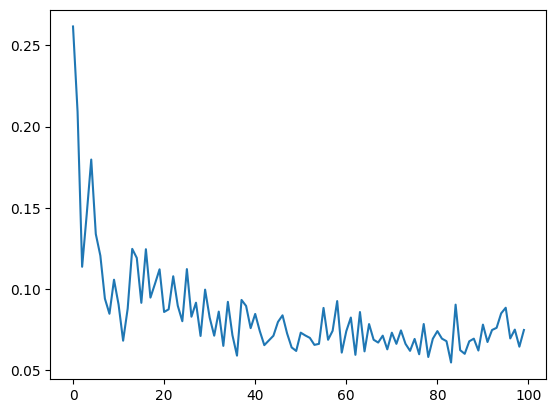

In [10]:
plt.plot(chamfer)

In [15]:
torch.save(model.state_dict(), 'diff_model_smiley.pth')

In [12]:
# state_dict = torch.load("diff_model3.pth")
# model = NoisePredictionMLP()
# model.load_state_dict(state_dict)

In [13]:
#run model on some points
test_x = [np.random.normal(0,2) for i in range(100)]
test_y = [np.random.normal(0,2) for i in range(100)]

ddim_data, _ = sample_ddim(model, 1000, alpha_bars, inference_steps=100, eta=0.0)

DDIM Sampling with 100 steps...


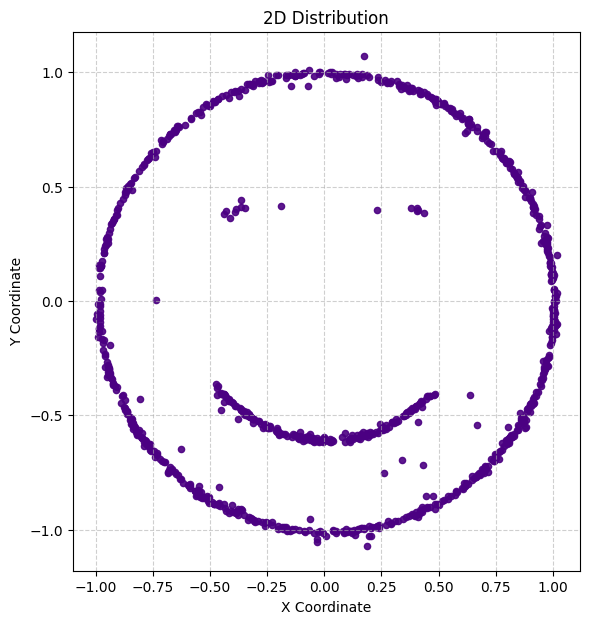

In [14]:

plot_points(ddim_data[:, 0], ddim_data[:, 1])